In [1]:
from IPython.core.display import HTML

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from scipy.integrate import odeint
from IPython.display import HTML

from scipy.fft import fft, ifft


# Pseudospectral method

based on the code in:´

https://www.youtube.com/watch?v=rsdqvrldgHM&list=WL&index=181

In [5]:
def rhsf(u,t,v,L):
    N = len(u)
    n = np.arange(N); n[int(N/2)+1:]-= N
    return -u*ifft(2*np.pi*1j*n/L*fft(u)).real - v*ifft((2*np.pi*n/L)**2*fft(u)).real

def modified_diffusion(q,t,w_x,a):
    N = len(q)
    n = np.arange(N); n[int(N/2)+1:]-= N
    return - w_x*q + a *ifft((2*np.pi*n/L)**2*fft()).real

def spectral(nx, system_length, time_span, diff_eq, args_eq):
    
    #---------- solution domain, initial condition
    
    dx = system_length/nx     # not L/(nx-1)
    # initial condition
    x = np.linspace(0.0, system_length-dx, nx)
    
    
    u0 = np.cos(2*np.pi*x/system_length) + 2
    
    #---------- solve the problem
    
    t = np.linspace(0,time_span,11)
    # (v,system_length)
    u = odeint(rhsf, u0, t, args=args_eq)
    
    return x, u, u0

x,u,u0 = spectral(32, 10, 10, rhsf, (0.1,10))

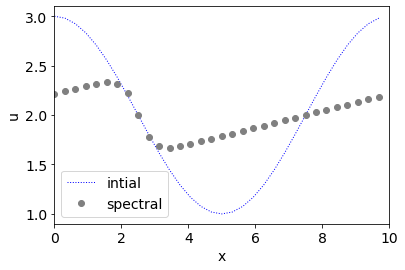

In [6]:

fig,ax=plt.subplots()
ax.plot(x,u0, ':', color='blue', lw=1,label='intial')
ax.plot(x,u[-1,:], 'o', color='gray', lw=1, label='spectral')
    
plt.rc('font', size=14)
plt.gca().set_xlim([0,10])
plt.xlabel('x')
plt.ylabel(r'u');
plt.legend();
